In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tmr.pim_tmr as pim
import utils.matrices as pim_mats
import fibernet
import torch
from tmr.tmr import TMR
import matplotlib.pyplot as plt

from tmr.pim_tmr import wirtinger_initialization
from utils.utils import get_subsets, select_pixels, crop_img

import mat73
import os
from scipy.io import loadmat

In [2]:
path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_0deg.mat"
data = mat73.loadmat(os.path.join(path, file))
# data = loadmat(os.path.join(path, file))

CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

In [3]:
NN = CP.shape[0]
As = np.zeros(shape=(NN, 32), dtype=complex)
Bs = np.zeros(shape=(NN, 122*122), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

idxs = np.arange(4, 122, 128/30).astype(int)
print(idxs.shape)
Bs = np.zeros(shape=(NN, len(idxs)**2), dtype=float)

for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    phi = np.exp(1j * phi)
    phi = np.delete(vec[i], [0, 5, 30, 35])
    img = crop_img(CP[i], crop=3)
    img = select_pixels(img, idxs)
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img)


(28,)


Iteration:   1 - distance = 4.699e-01 - stopping distance = 8.969e-02
Iteration:   2 - distance = 4.236e-01 - stopping distance = 4.637e-02
Iteration:   3 - distance = 3.998e-01 - stopping distance = 2.375e-02
Iteration:   4 - distance = 3.857e-01 - stopping distance = 1.417e-02
Iteration:   5 - distance = 3.757e-01 - stopping distance = 9.951e-03
Iteration:   6 - distance = 3.674e-01 - stopping distance = 8.341e-03
Iteration:   7 - distance = 3.591e-01 - stopping distance = 8.220e-03
Iteration:   8 - distance = 3.507e-01 - stopping distance = 8.410e-03
Iteration:   9 - distance = 3.426e-01 - stopping distance = 8.105e-03
Iteration:  10 - distance = 3.350e-01 - stopping distance = 7.620e-03
Iteration:  11 - distance = 3.281e-01 - stopping distance = 6.946e-03
Iteration:  12 - distance = 3.218e-01 - stopping distance = 6.307e-03
Iteration:  13 - distance = 3.158e-01 - stopping distance = 5.945e-03
Iteration:  14 - distance = 3.103e-01 - stopping distance = 5.518e-03
Iteration:  15 - dis

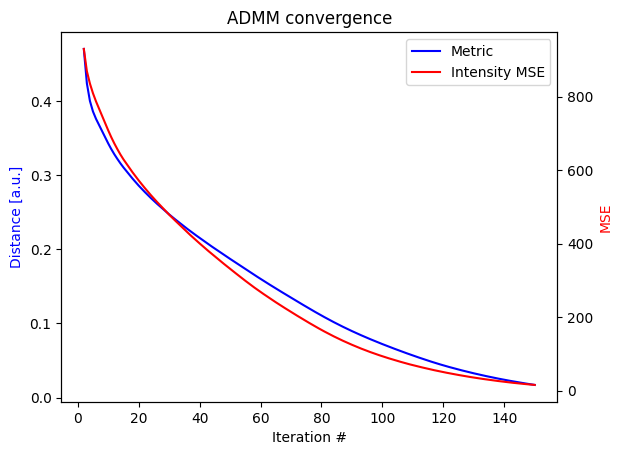

In [10]:
torch.cuda.empty_cache()
As_crop, Bs_crop = get_subsets(As, Bs, N=51, randomize=True)

# Tolerance criterion has to be adjusted to be realistic and ensure the convergence
# init = wirtinger_initialization(As_crop, Bs_crop)
# X_est = pim.pim_tmr(As_crop, Bs_crop, max_iter=100, tol=12e-9, tol_stag=1e-2, max_stag=10)

tmr = TMR(As_crop, Bs_crop, verbose=True, device='cuda')
tmr.run_admm(max_iter=150, lr=1e-3, tol=1e-9, rho=0.25)
tmr.print_results()
tmr.show_results()

[(-0.5, 27.5, 27.5, -0.5), (-0.5, 27.5, 27.5, -0.5), (-0.5, 27.5, 27.5, -0.5)]

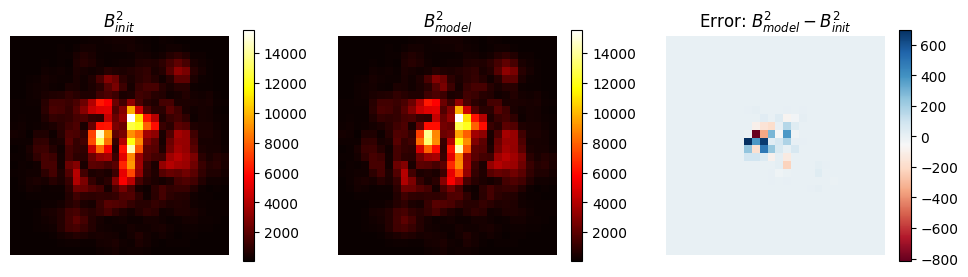

In [11]:
# i = np.random.randint(0, N)
i = 50
A_init = As_crop

Y_model = np.dot(A_init, tmr.X_best)
B_model = np.abs(Y_model)
B_init = Bs_crop

b_init_check = np.reshape(B_init[i,:], (len(idxs),len(idxs)))
b_model_check = np.reshape(B_model[i,:], (len(idxs),len(idxs)))

fig, axs = plt.subplots(1,3, figsize=(12,3))
pl0 = axs[0].imshow(np.square(b_init_check ), cmap="hot")
pl1 = axs[1].imshow(np.square(b_model_check), cmap="hot", vmin=np.min(np.square(b_init_check )), vmax=np.max(np.square(b_init_check )))
pl2 = axs[2].imshow(np.square(b_model_check) - np.square(b_init_check), cmap="RdBu")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])
plt.colorbar(pl2, ax=axs[2])
axs[0].set_title(r"$B_{init}^2$")
axs[1].set_title(r"$B_{model}^2$")
axs[2].set_title(r"Error: $B_{model}^2 - B_{init}^2$")
[ axs[i].axis('off') for i in range(len(axs)) ]